# Dataset from Kaggle

https://www.kaggle.com/datasets/piyushagni5/monthly-sales-of-french-champagne

# Import Library

In [1]:
# !pip install statsmodels --upgrade
import warnings
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
warnings.filterwarnings('ignore')

# Load the Dataset

In [2]:
dataset = pd.read_csv("monthly_champagne_sales.csv")
dataset.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [3]:
# Rename the columns name
dataset.rename(columns={"Month": "Date", "Sales": "Total_Sales"}, inplace = True)

In [4]:
# Information of the dataset such as number of samples, colmns, data type, Non-Null value and how much memory size use.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         105 non-null    object
 1   Total_Sales  105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [5]:
# Convert the date column to a datetime object and set it as the index
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)
dataset.head()

,Total_Sales
Date,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [6]:
dataset.shape

(105, 1)

In [7]:
# Check duplicate index
dataset.index.duplicated().sum()

0

In [8]:
dataset.describe()

,Total_Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


# Visualize the Data

<Axes: xlabel='Date'>

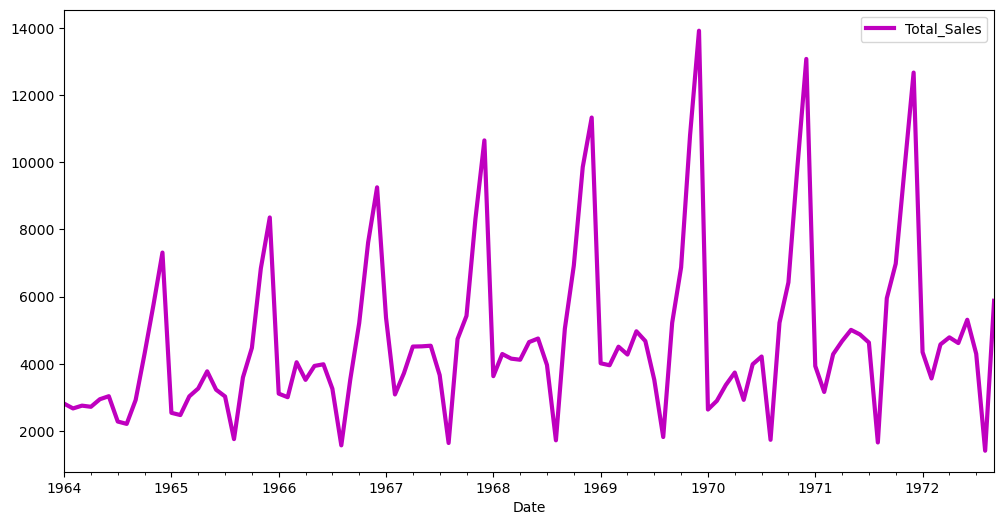

In [14]:
dataset.plot(c = 'm', linewidth=3, figsize=(12,6))

# Data Preprocessing

Check Missing Value of the dataset

In [15]:
dataset.isnull().sum()

Total_Sales    0
dtype: int64

In [16]:
# Remove Null Value
# dataset = dataset.ffill() #interpolate()

Rolling/Moving Average

Text(0, 0.5, 'Sales')

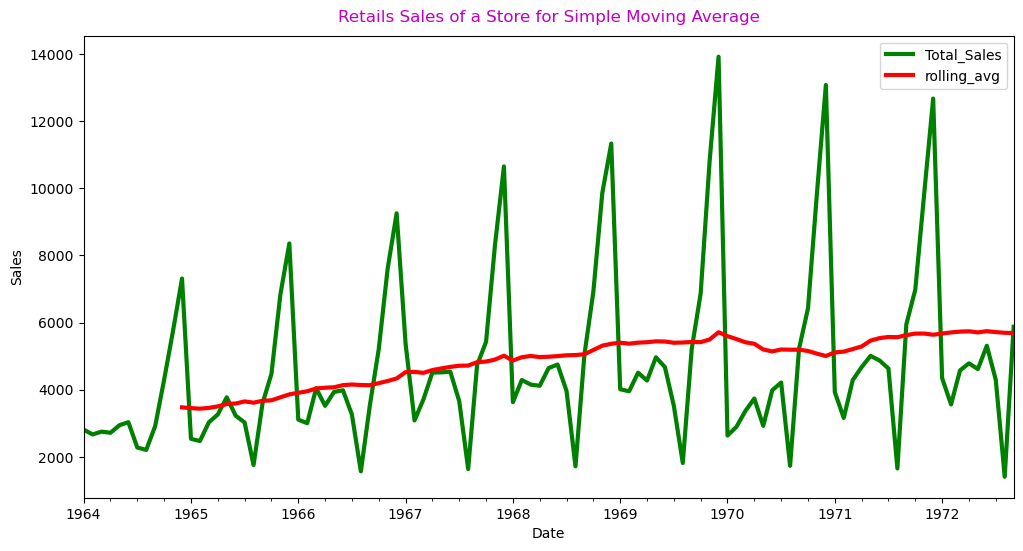

In [17]:
dataset['rolling_avg'] = dataset.Total_Sales.rolling(12).mean()
colors = ['g', 'r']
dataset[["Total_Sales", "rolling_avg"]].plot(color=colors, linewidth=3, figsize=(12,6))
plt.title("Retails Sales of a Store for Simple Moving Average", pad = 10, c = 'm')
plt.xlabel('Date')
plt.ylabel('Sales')


Dickey Fuller Test for testing Stationary

In [18]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

        
adfuller_test(dataset['Total_Sales'])

ADF Test Statistic : -1.8335930563276297
p-value : 0.3639157716602417
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Differencing for getting Stationary

In [19]:
dataset['Sales First Difference']=dataset['Total_Sales']-dataset['Total_Sales'].shift(1)

dataset['Seasonal First Difference']=dataset['Total_Sales']-dataset['Total_Sales'].shift(12)
dataset.head(15)

,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference
Date,,,,
1964-01-01,2815,NaN,NaN,NaN
1964-02-01,2672,NaN,-143.0,NaN
1964-03-01,2755,NaN,83.0,NaN
1964-04-01,2721,NaN,-34.0,NaN
1964-05-01,2946,NaN,225.0,NaN
1964-06-01,3036,NaN,90.0,NaN
1964-07-01,2282,NaN,-754.0,NaN
1964-08-01,2212,NaN,-70.0,NaN
1964-09-01,2922,NaN,710.0,NaN


In [20]:
adfuller_test(dataset['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213163
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


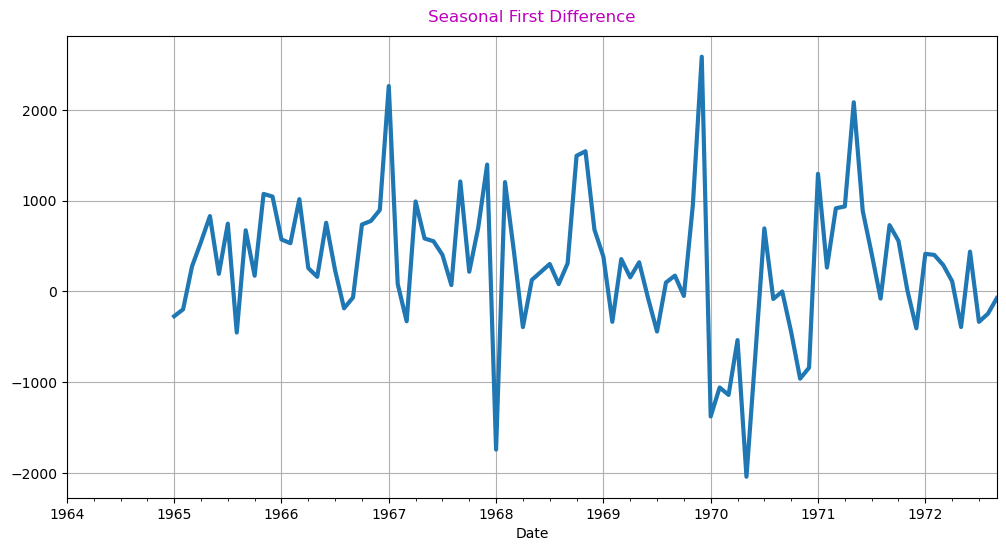

In [21]:
dataset["Seasonal First Difference"].plot(linewidth=3, figsize=(12,6))
plt.title("Seasonal First Difference", pad = 10, c = 'm')
plt.grid()

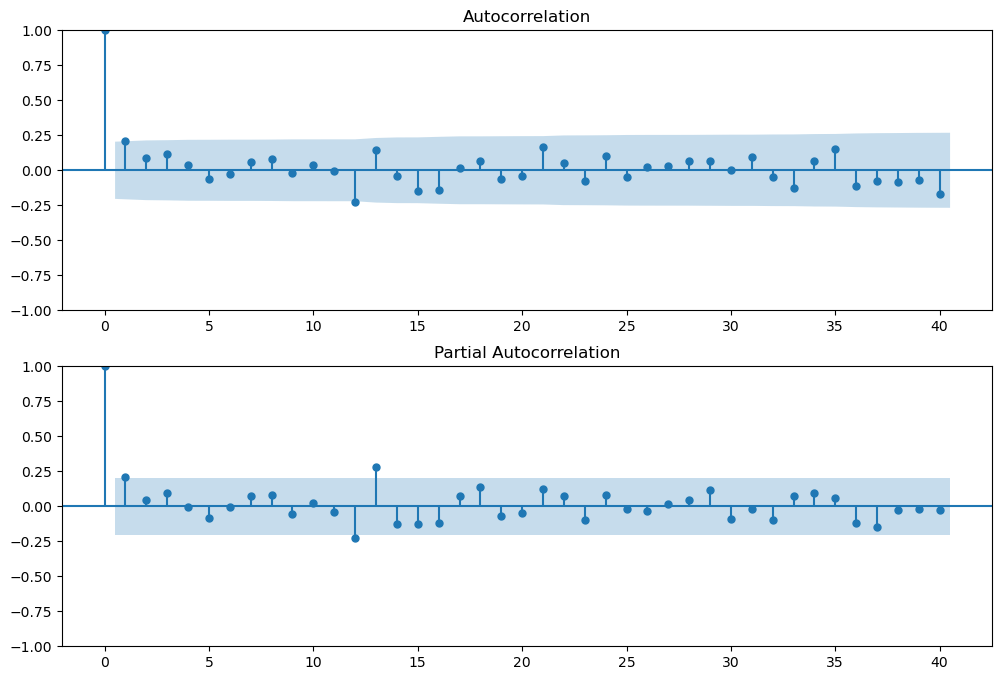

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(dataset['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(dataset['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

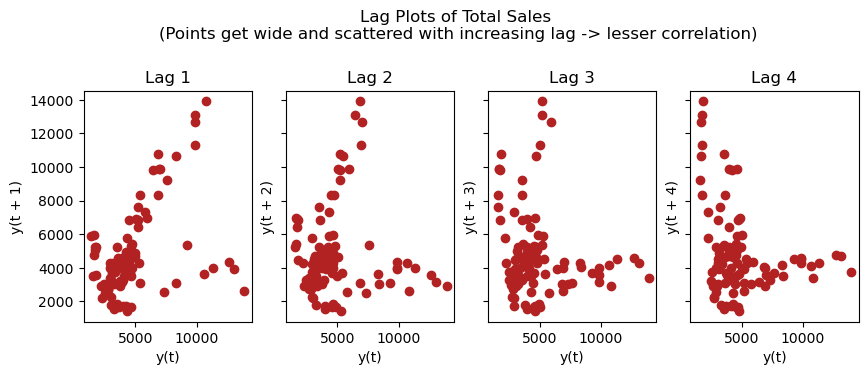

In [23]:
from pandas.plotting import lag_plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(dataset.Total_Sales, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Total Sales \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)      
plt.show();

In [24]:
training_size = int(len(dataset)*0.9)
train_data, test_data = dataset[0:training_size],dataset[training_size:len(dataset)-1] 

"Grid Search" to find the optimal set of parameters.

In [31]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
aic = []
params = []
param_seasonals = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataset["Seasonal First Difference"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            params.append(param)
            aic.append(results.aic)
            param_seasonals.append(param_seasonal)
        except:
            continue
print("\n\nOptimal Set of Parameters based on AIC: \n")          
min_values_index_aic = np.argmin(aic)
print('SARIMA{}x{} - AIC:{}'.format(params[min_values_index_aic], param_seasonals[min_values_index_aic], aic[min_values_index_aic]))

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1511.2713844170698
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1497.4352397678579
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1575.261238249959
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1317.1692257539469
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1512.6366920013731
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1499.2551126445428
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1349.3150462276506
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1315.1974743765609
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1505.458970282013
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1474.4403691246064
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1559.0691094630706
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1300.1430544893065
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1503.873328742843
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1475.086541859423
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1346.0030792811835
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1295.6356402566244
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1542.8688000304508
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - A

# Model Selection & Training

SARIMA Model

In [ ]:
model=sm.tsa.statespace.SARIMAX(train_data['Total_Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

In [ ]:
print(results.summary().tables[1])

In [ ]:
prediction_SARIMA = results.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=True)
plt.figure(figsize=(12,6))
prediction_SARIMA.plot(linewidth=3,label = "Prediction of SARIMA", c = 'r')
test_data['Total_Sales'].plot(linewidth=3, label = "Total Sales")
plt.title('Prediction vs Test Data of SARIMA Model', color = 'm', size = 15, pad = 10)
plt.legend()

# Model Evaluation

In [ ]:
print("Mean of Test Data: ", test_data["Total_Sales"].mean())
root_mean_square_error_SARIMA = np.sqrt(mean_squared_error(test_data["Total_Sales"], prediction_SARIMA))
print("Mean Suare Error of SARIMA Model : ", round(root_mean_square_error_SARIMA,2))

# Future Sales Prediction

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[dataset.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [ ]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=dataset.columns)
future_datest_df.tail()

In [ ]:
future_df=pd.concat([dataset,future_datest_df])
future_df

In [ ]:
future_df['forecast'] = results.predict(start = len(train_data)-1, end = 120, dynamic= True)  
future_df[['Total_Sales', 'forecast']].plot(linewidth=3, figsize=(12,6)) 

# LSTM Model

In [ ]:
train_data = train_data.drop(["rolling_avg", "Sales First Difference",  "Seasonal First Difference"], axis = 1)
test_data = test_data.drop(["rolling_avg", "Sales First Difference",  "Seasonal First Difference"], axis = 1)

In [ ]:
tf.keras.utils.set_random_seed(1)
# Data Scaling
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

In [ ]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size= 1)

In [ ]:
#Define Model
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss = 'mse')

In [ ]:
model.summary()

In [ ]:
#fit model
model.fit(generator, epochs = 600)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, c = "r", label = "Loss")
plt.title('Loss per epoch', color = 'red', size = 15, pad = 10)
plt.legend()
     

In [ ]:
last_train_batch = scaled_train[-n_input:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

In [ ]:
scaled_test.shape

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test_data)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [ ]:
predictions_LSTM = scaler.inverse_transform(test_predictions)

In [ ]:
test_data["predictions_LSTM"] = predictions_LSTM

In [ ]:
plt.figure(figsize=(12,6))
test_data["predictions_LSTM"].plot(linewidth=3, label = "Prediction of LSTM", c = 'r')
test_data['Total_Sales'].plot(linewidth=3, label = "Total Sales")
plt.title('Total Sales of Test Data vs Predictions OF LSTM', color = 'red', size = 15, pad = 10)
plt.legend()

In [ ]:
root_mean_square_error_LSTM = np.sqrt(mean_squared_error(test_data['Total_Sales'], test_data["predictions_LSTM"]))
print("Root Mean Square Error of LSTM Model : ", round(root_mean_square_error_LSTM, 2))

In [ ]:
plt.figure(figsize=(12,6))
prediction_SARIMA.plot(linewidth=3, label = "Prediction of SARIMA", c = 'm')
test_data["predictions_LSTM"].plot(linewidth=3, label = "Prediction of LSTM", c = 'r')
test_data['Total_Sales'].plot(linewidth=3, label = "Total Sales")
plt.title('Total Sales of Test Data vs Predictions', color = 'red', size = 15, pad = 10)
plt.legend()

#### 